# Ben's Phase 1 Project Notebook

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
imdb_titles = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
imdb_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
imdb_principals = pd.read_csv('zippedData/imdb.title.principals.csv.gz')
imdb_crews = pd.read_csv('zippedData/imdb.title.crew.csv.gz')
imdb_akas = pd.read_csv('zippedData/imdb.title.akas.csv.gz')
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

In [3]:
rt_kaggle = pd.read_csv('zippedData/rotten_tomatoes_movies.csv')
rt_movies = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding = 'unicode_escape')

# Rotten Tomatoes Databases from zippedData
rt_movies is a dataset from Rotten Tomatoes of 1560 records over 12 columns.  Unfortunately, there are no movie titles, so it is not possible to merge this dataset with the imdb_cleaned dataset.  Therefore this rt_movies will remain an 'island'. Another downside is that the box_office records are limited to 340.  Nevertheless, we used this dataset to further elucidate the larger imdb dataset (combined with tmdb and tn). (Note:  it is not specified whether box office numbers are domestic or worldwide but, given there values, we are assuming these are gross domestice numbers.  This will contrast with our larger combined dataset which uses a worldwide net.)
## rt_movies.csv
### Cleaning rt_movies

In [4]:
rt_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [5]:
#Create rt_movies_cleaned. Drop 359 movies with no theater date.  Only reduces records with B.O. from 340 to 334.
rt_movies_cleaned = rt_movies.dropna(axis=0, subset=['theater_date'])

#Create new column 'year' for int year, and 'month' for the month str.
rt_movies_cleaned['year'] = rt_movies_cleaned.theater_date.apply(lambda x: x.split()[-1])
rt_movies_cleaned['month'] = rt_movies_cleaned.theater_date.apply(lambda x: x.split()[0])

#Remove all movies with no box office records.  Now have 334 records.
rt_movies_cleaned.dropna(axis=0, subset=['box_office'], inplace=True)
rt_movies_cleaned.reset_index(inplace=True)
rt_movies_cleaned.drop('index', axis=1, inplace=True)

In [6]:
#Remove commas from B.O. column
rt_movies_cleaned.box_office = rt_movies_cleaned.box_office.apply(lambda x: x.replace(',',''))

#Convert B.O. to ints
rt_movies_cleaned.box_office = rt_movies_cleaned.box_office.apply(lambda x: int(x))

#Convert years to ints
rt_movies_cleaned.year = rt_movies_cleaned.year.apply(lambda x: int(x))

In [7]:
#Remove all movies before 2000.  Reduces records to 326.
rt_movies_cleaned = rt_movies_cleaned[rt_movies_cleaned.year >= 2000]

In [8]:
#Find movie with rating NC17, then drop the record.  There are 325 records remaining.  
rt_movies_cleaned[rt_movies_cleaned.rating == 'NC17'].index

Int64Index([259], dtype='int64')

In [9]:
rt_movies_cleaned.drop(259, axis=0, inplace=True)

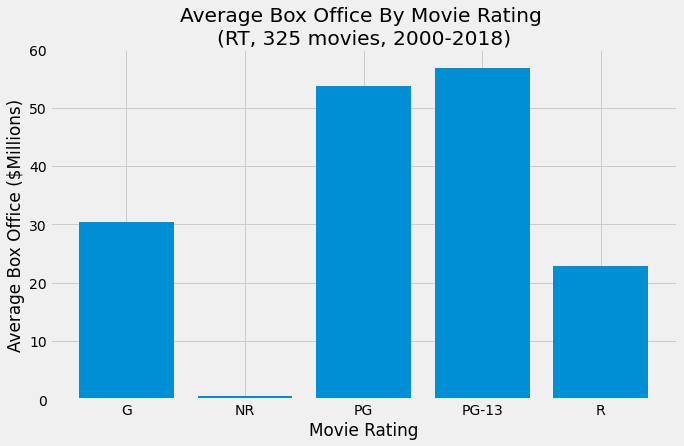

In [10]:
#Rotten Tomatoes db of 325 movies from 2000 to 2018
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_cleaned.groupby('rating').box_office.mean().index
y = rt_movies_cleaned.groupby('rating').box_office.mean().values
ax.bar(x,y)
ax.set_xlabel('Movie Rating')
ax.set_ylabel('Average Box Office ($Millions)')
ax.set_title('Average Box Office By Movie Rating \n(RT, 325 movies, 2000-2018)')
ax.set_yticks(range(0,70000000,10000000))
ax.set_yticklabels(range(0,70,10));

In [11]:
rt_movies_cleaned.rating.value_counts()

R        139
PG-13    115
PG        49
NR        13
G          9
Name: rating, dtype: int64

Note:  There are only 9 G rated films included in the above plot, therefore we should not strongly rely on it's conclusions.

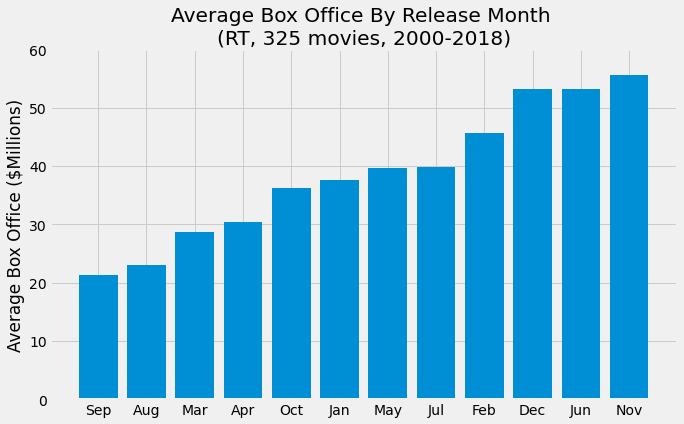

In [12]:
#Create a plot of Average BO by release month from rt_movies_cleaned
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_cleaned.groupby('month').box_office.mean().sort_values().index
y = rt_movies_cleaned.groupby('month').box_office.mean().sort_values().values
ax.bar(x,y)
ax.set_ylabel('Average Box Office ($Millions)')
ax.set_title('Average Box Office By Release Month \n(RT, 325 movies, 2000-2018)')
ax.set_yticks(range(0,70000000,10000000))
ax.set_yticklabels(range(0,70,10));

The above plot is a useful comparison to a similar plot generated with the larger dataset.

### rt_movies_runtime
Clean the dataset further to examine movie runtime vs. box office.

In [13]:
#create a subset of rt_movies_cleaned to remove NaNs from runtime, leaving 323 records
rt_movies_runtime = rt_movies_cleaned.dropna(axis=0, subset=['runtime'])

In [14]:
#create a new column 'minutes' that contains minutes in ints
rt_movies_runtime['minutes'] = rt_movies_runtime.runtime.apply(lambda x: int(x.split()[0]))

In [15]:
#Find the correlation between box office and runtime.
rt_movies_runtime.corr()

,id,box_office,year,minutes
id,1.000000,0.079440,0.015652,0.031163
box_office,0.079440,1.000000,-0.165534,0.232658
year,0.015652,-0.165534,1.000000,0.099582
minutes,0.031163,0.232658,0.099582,1.000000


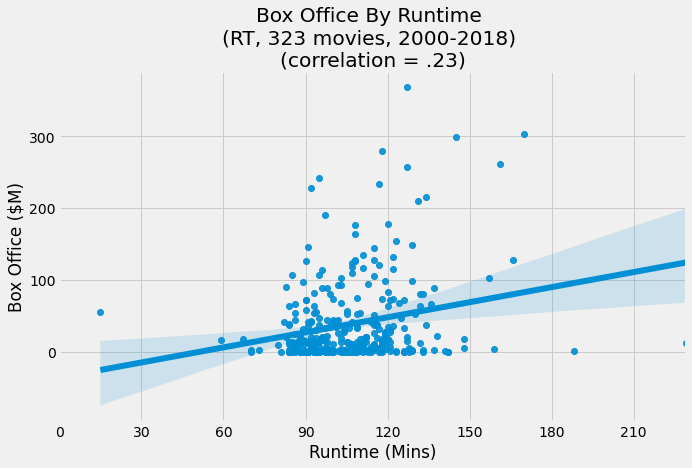

In [16]:
#Scatter plot of B.O. by runtime from RT db with 323 movies from 2000-2018
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_runtime.minutes
y = rt_movies_runtime.box_office
ax.scatter(x=x, y=y, alpha=.5)
sns.regplot(x=x,y=y)
ax.set_xlabel('Runtime (Mins)')
ax.set_ylabel('Box Office ($M)')
ax.set_title('Box Office By Runtime \n(RT, 323 movies, 2000-2018) \n(correlation = .23)')
ax.set_xticks(range(0,240, 30))
ax.set_yticks(range(0,400000000,100000000))
ax.set_yticklabels(range(0,400,100));

Note:  There is a weak positive correlelation between runtime and box office.  The above plot will be compared to a similar plot generated with the larger dataset.

### rt_movies_directors
Further cleaning to inspect box office by director.

In [17]:
#create rt_movies_directors with 286 records by dropping NaNs from rt_movies_cleaned
rt_movies_directors = rt_movies_cleaned.dropna(axis=0, subset=['director'])

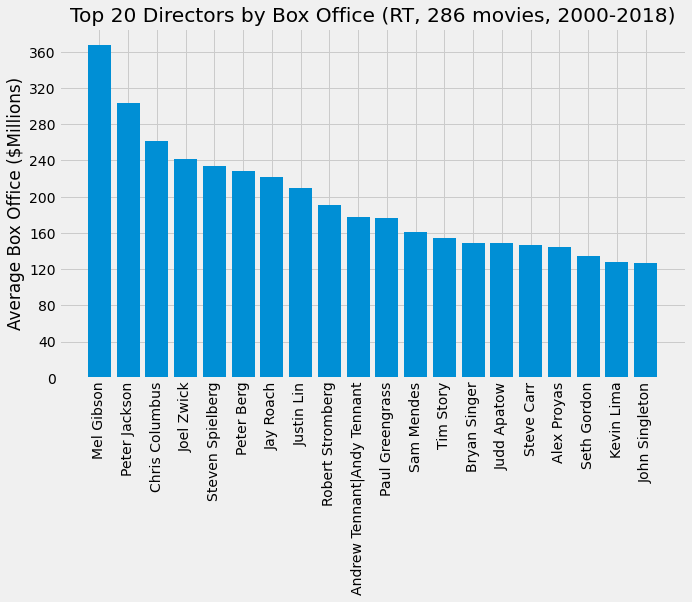

In [18]:
#Plot top 20 directors by mean B.O. Not very informative because most directors have only one movie listed.
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_directors.groupby('director').box_office.mean().sort_values(ascending=False)[:20].index
y = rt_movies_directors.groupby('director').box_office.mean().sort_values(ascending=False)[:20].values
ax.bar(x,y)
ax.set_ylabel('Average Box Office ($Millions)')
ax.set_title('Top 20 Directors by Box Office (RT, 286 movies, 2000-2018)')
ax.set_xticks(range(20))
ax.set_xticklabels(x, rotation=90)
ax.set_yticks(range(0,400000000,40000000))
ax.set_yticklabels(range(0,400,40));

Note:  The above plot is rather useless because most directors have only one or two movies in the dataset.  Mel Gibsion's movie, for example, is probably 'Passion of the Christ', which was a b.o. smash, but that doesn't tell us anything about his other directorial ventures.

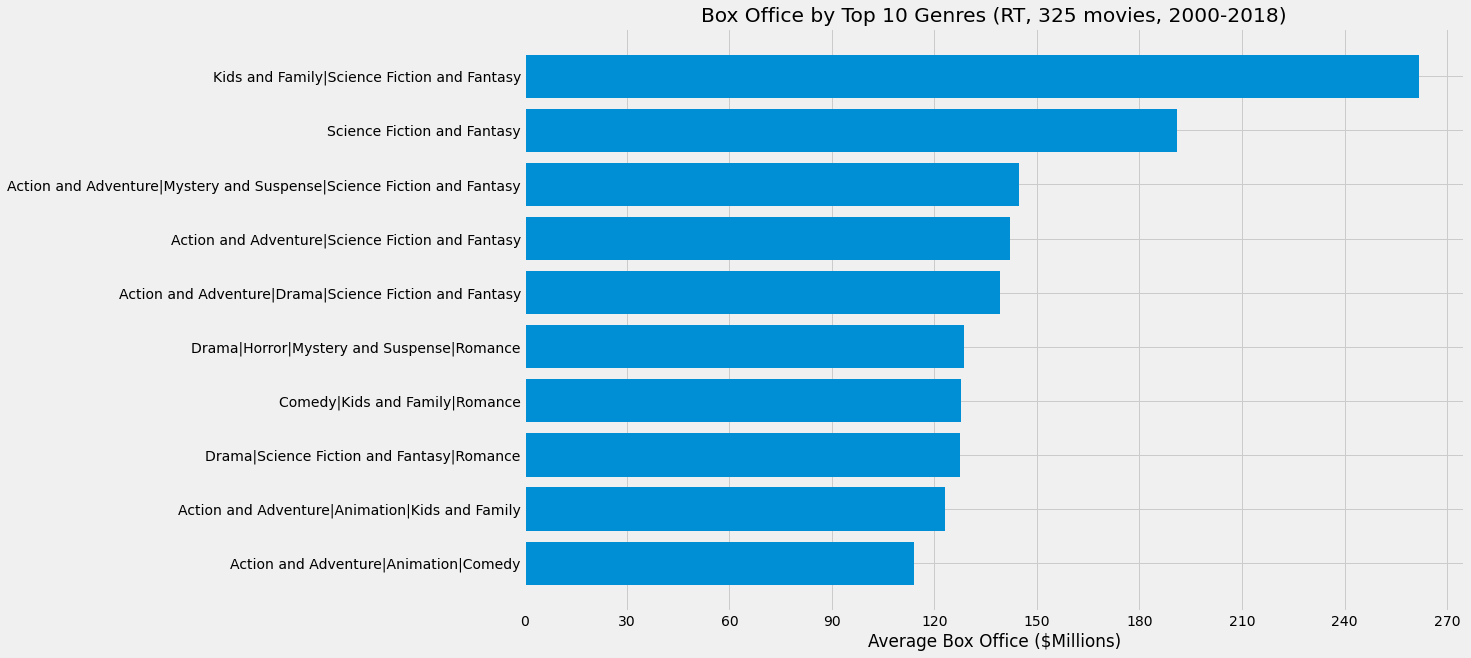

In [19]:
#Create a plot showing top 10 genres by B.O. using rt_movies_cleaned (325 records)
fig, ax = plt.subplots(figsize=(15,10))
x = rt_movies_cleaned.groupby('genre').box_office.mean().sort_values(ascending=False)[:10].sort_values().index
y = rt_movies_cleaned.groupby('genre').box_office.mean().sort_values(ascending=False)[:10].sort_values().values
ax.barh(x,y)
ax.set_xlabel('Average Box Office ($Millions)')
ax.set_title('Box Office by Top 10 Genres (RT, 325 movies, 2000-2018)')
ax.set_xticks(range(0,300000000,30000000))
ax.set_xticklabels(range(0,300,30));

Note:  The above plot will be a useful comparison with one generated from the larger datasets.

# rt_reviews.csv
rt_reviews is another Rotten Tomatoes dataset with 54,432 records over 8 columns.  It consists of reviews for each movie id as well as RT ratings.  Most movies have many reviews, though only some of them are from top critics.  We are attempting to find a correlation between top critics' opinion and box office return.  This dataset will be filtered to only top critics and merged with rt_movies to generate the plot.

In [20]:
rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [21]:
#Remove all records where top_critic = 0. Reduces rt_reviews from 54,432 to 13,096 records
rt_reviews = rt_reviews[rt_reviews.top_critic == 1]

In [22]:
#Create new column 'fresh_value' that is 1 for 'fresh' movies or 0 for 'rotten' movies.
rt_reviews['fresh_value'] = rt_reviews.fresh.apply(lambda x: 1 if x == 'fresh' else 0)

In [23]:
#Create a series of the percentage of fresh reviews for each movie id (889 records)
total_reviews = rt_reviews.groupby('id').fresh_value.count()
fresh_reviews = rt_reviews.groupby('id').fresh_value.sum()
fresh_percent = fresh_reviews / total_reviews 

In [24]:
#Create a series of the number of reviews for each movie id (889 records)
num_reviews = rt_reviews.groupby('id').id.count()

In [25]:
#Merege the two series and rename the columns
merge_fresh_and_num_reviews = pd.concat([fresh_percent, num_reviews], axis=1)
merge_fresh_and_num_reviews.rename(columns={'id':'num_reviews'}, inplace=True)

In [26]:
#Remove all records with less than 10 reviews, leaving 447 records.
merge_fresh_and_num_reviews = merge_fresh_and_num_reviews[merge_fresh_and_num_reviews.num_reviews >= 10]

In [27]:
#inner merge rt_movies_cleaned with the series fresh percent into rt_movies_cleaned_reviews (268 records)
rt_movies_cleaned_reviews = rt_movies_cleaned.merge(merge_fresh_and_num_reviews, how='inner', on='id')

In [28]:
#Find the correlation between box office and fresh_value
rt_movies_cleaned_reviews.corr()['box_office']['fresh_value']

0.03613542398884145

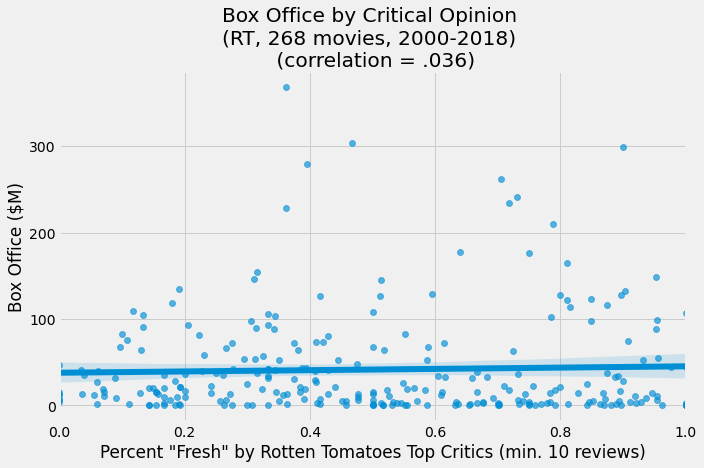

In [45]:
#Create a scatter plot of BO and critical opinion.
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_cleaned_reviews.fresh_value
y = rt_movies_cleaned_reviews.box_office
ax.scatter(x, y , alpha=.5)
sns.regplot(x=x, y=y, scatter_kws={'alpha':0.3})
ax.set_xlabel('Percent \"Fresh\" by Rotten Tomatoes Top Critics (min. 10 reviews)')
ax.set_ylabel('Box Office ($M)')
ax.set_title('Box Office by Critical Opinion \n(RT, 268 movies, 2000-2018) \n (correlation = .036)')
ax.set_yticks(range(0,400000000,100000000))
ax.set_yticklabels(range(0,400,100));

As you can see, there is almost no correlation between RT top critics opinion and box office returns.

# imdb_cleaned -- further analysis
Using our large, combined dataset, we are further investigating an additional question:  are there higher box office returns for movies released during certain months?  And, additionally, are movies released in certain months for critically acclaimed?

In [30]:
imdb_cleaned = pd.read_csv('https://raw.githubusercontent.com/nate-walter/phase-1-project-mvp-repo/imdb_branch/Data/imdb_cleaned_final.csv')

In [31]:
imdb_cleaned_copy = imdb_cleaned.copy()

In [32]:
#drop all movie duplicates since I'm only interested in the release month
imdb_cleaned_copy.drop_duplicates(subset='tconst', inplace=True)

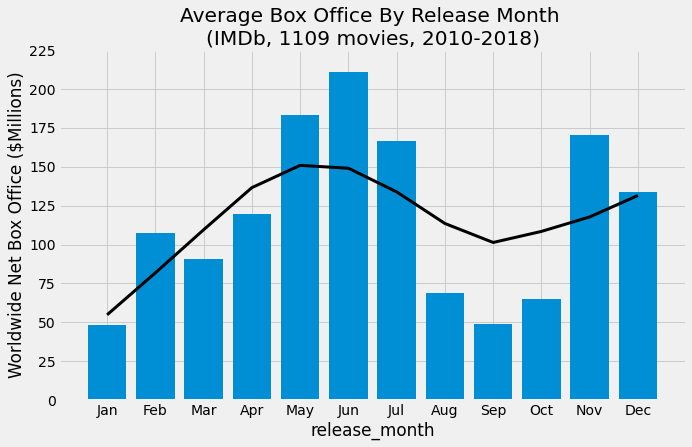

In [33]:
#create a plot WW net BO by release month using imdb_cleaned_copy
fig, ax = plt.subplots(figsize=(10,6))
x = imdb_cleaned_copy.groupby('release_month')['Worldwide Net Profit'].mean().index
y = imdb_cleaned_copy.groupby('release_month')['Worldwide Net Profit'].mean().values
ax.bar(x,y)
ax = sns.regplot(x, y, scatter = False,  color = 'black', lowess = True, line_kws={'linewidth':3})

ax.set_ylabel('Worldwide Net Box Office ($Millions)')
ax.set_title('Average Box Office By Release Month \n(IMDb, 1109 movies, 2010-2018)')
ax.set_yticks(range(0,250000000,25000000))
ax.set_yticklabels(range(0,250,25))

month_starts = range(1,13,1)
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec'] 
ax.set_xticks(month_starts)
ax.set_xticklabels(month_names);

Note:  The plot shows strong returns for movies released in the spring months (May, June, Jul) as well as at the end of the year (Nov, Dec).  

In [34]:
#find correlation betweeen average IMDb rating and release month
imdb_cleaned_copy.corr()['averagerating']['release_month']

0.19224405323134594

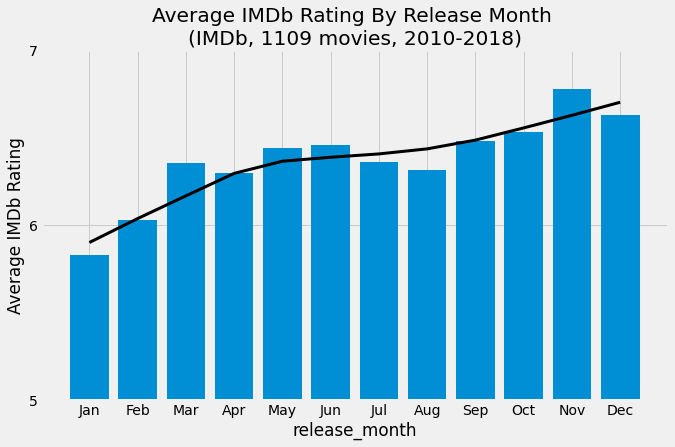

In [35]:
#create a plot average IMDb rating by relase month using imdb_cleaned_copy
fig, ax = plt.subplots(figsize=(10,6))
x = imdb_cleaned_copy.groupby('release_month').averagerating.mean().index
y = imdb_cleaned_copy.groupby('release_month').averagerating.mean().values
ax.bar(x,y)
ax = sns.regplot(x, y, scatter = False,  color = 'black', lowess = True, line_kws={'linewidth':3})

ax.set_ylabel('Average IMDb Rating')
ax.set_title('Average IMDb Rating By Release Month \n(IMDb, 1109 movies, 2010-2018)')
ax.set_yticks(range(5,8,1))
ax.set_yticklabels(range(5,8,1))
ax.set_ylim(bottom=5, top=7)

month_starts = range(1,13,1)
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec'] 
ax.set_xticks(month_starts)
ax.set_xticklabels(month_names);

Note:  IMDb rating tends to increase as the year progresses.  This intuitivley makes sense, since movies vying for Oscar attention schedule their releases closer to the nomination period.

# Rotten Tomatoes Data From Kaggle
We further investigate Rotten Tomatoes using a dataset from Kaggle.  This data was webscraped and consists of 17,712 records over 22 columns.  Fortunately, this RT dataset includes the movie title so, unlike rt_reviews, it can be merged with our imdb combined dataset.  We can then investigate worldwide profits vs. MPAA rating, genre, and the RT "tomatometer".

In [36]:
rt_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rotten_tomatoes_link              17712 non-null  object 
 1   movie_title                       17712 non-null  object 
 2   movie_info                        17391 non-null  object 
 3   critics_consensus                 9134 non-null   object 
 4   content_rating                    17712 non-null  object 
 5   genres                            17693 non-null  object 
 6   directors                         17518 non-null  object 
 7   authors                           16170 non-null  object 
 8   actors                            17360 non-null  object 
 9   original_release_date             16546 non-null  object 
 10  streaming_release_date            17328 non-null  object 
 11  runtime                           17398 non-null  float64
 12  prod

In [37]:
#Set the movie titles to lowercase.  Drop records with no original release date.  
#Add a year col for int years, then drop all movies before the year 2000.
rt_kaggle['movie_title'] = rt_kaggle.movie_title.apply(lambda x: x.lower())
rt_kaggle.dropna(axis=0, subset=['original_release_date'], inplace=True)
rt_kaggle['year'] = rt_kaggle.original_release_date.apply(lambda x: int(x[:4]))
rt_kaggle = rt_kaggle[rt_kaggle.year >= 2000]

In [38]:
#Create a new df from imdb_cleaned_copy with just two columns: primary_title and Worldwide Net Profit.  Then merge 
#on the movie names with rt_kaggle creating a df with 1098 movies.  
imdb_cleaned_copy_title_and_profit = imdb_cleaned_copy[['primary_title','Worldwide Net Profit']]
merge_imdb_rt_kaggle = imdb_cleaned_copy_title_and_profit.\
        merge(rt_kaggle, how='inner', left_on='primary_title', right_on='movie_title')

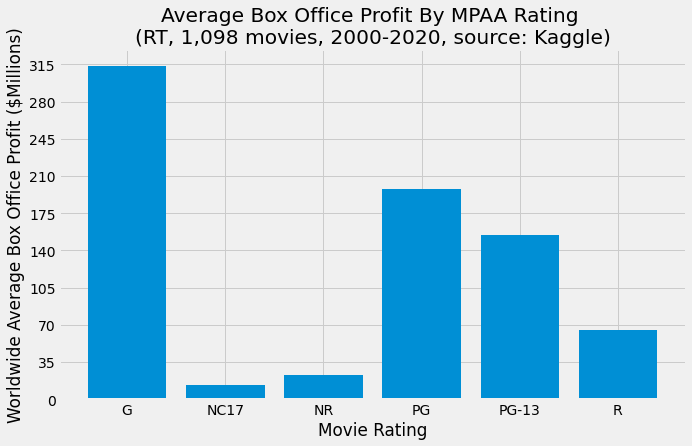

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
x = merge_imdb_rt_kaggle.groupby('content_rating')['Worldwide Net Profit'].mean().index
y = merge_imdb_rt_kaggle.groupby('content_rating')['Worldwide Net Profit'].mean().values
ax.bar(x,y)
ax.set_xlabel('Movie Rating')
ax.set_ylabel('Worldwide Average Box Office Profit ($Millions)')
ax.set_title('Average Box Office Profit By MPAA Rating \n(RT, 1,098 movies, 2000-2020, source: Kaggle)')
ax.set_yticks(range(0,350000000,35000000))
ax.set_yticklabels(range(0,350,35));

Note:  This graph contrasts with the rt_movies dataset (which suggested PG and PG-13 movies were making the most money) since it suggests that the biggest money-makers are G-rated movies.  This dataset and plot are preferable since a) it uses worldwide profit rather than domestic gross, and b) it's a larger dataset. It still has the weakness, however, of only including 13 G rated films.

In [40]:
merge_imdb_rt_kaggle.content_rating.value_counts()

R        464
PG-13    449
PG       161
G         13
NR        10
NC17       1
Name: content_rating, dtype: int64

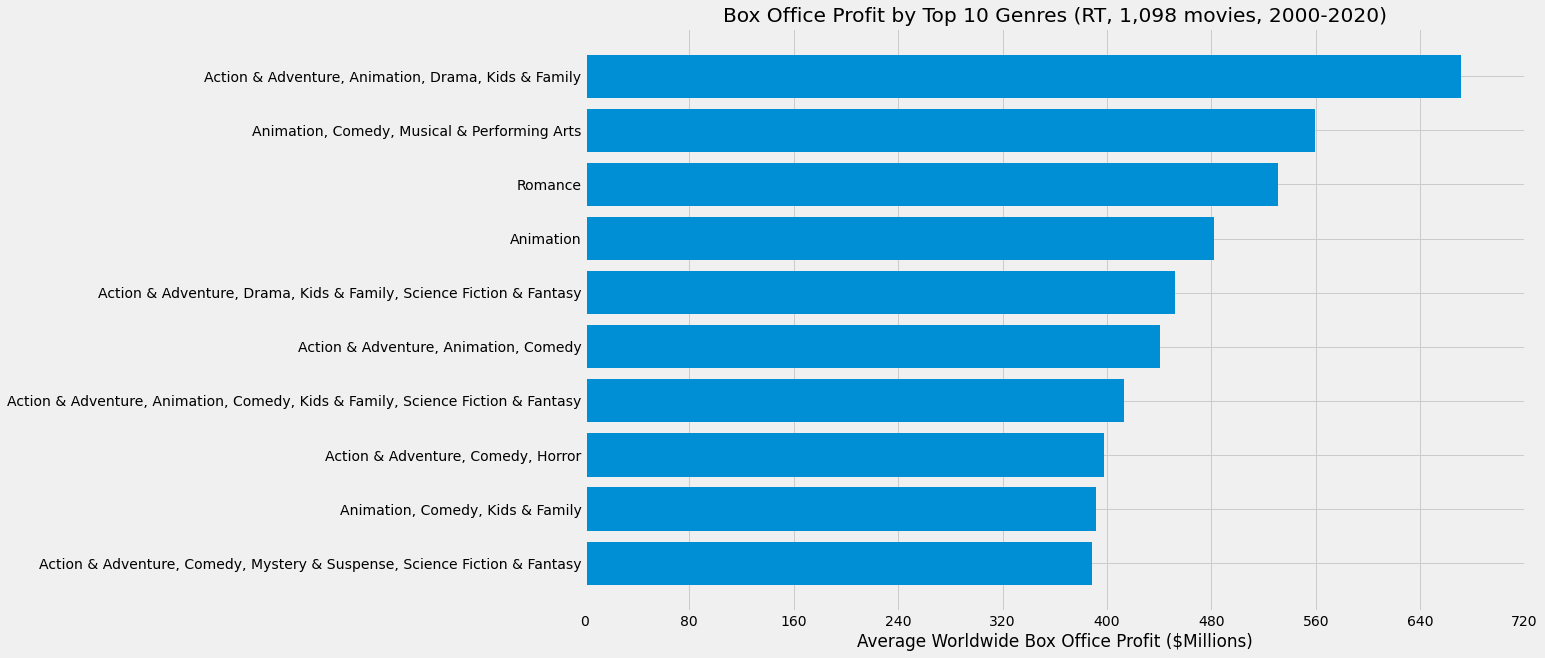

In [41]:
fig, ax = plt.subplots(figsize=(15,10))
x = merge_imdb_rt_kaggle.groupby('genres')['Worldwide Net Profit'].mean()\
            .sort_values(ascending=False)[:10].sort_values().index
y = merge_imdb_rt_kaggle.groupby('genres')['Worldwide Net Profit'].mean()\
            .sort_values(ascending=False)[:10].sort_values().values
ax.barh(x,y)
ax.set_xlabel('Average Worldwide Box Office Profit ($Millions)')
ax.set_title('Box Office Profit by Top 10 Genres (RT, 1,098 movies, 2000-2020)')
ax.set_xticks(range(0,800000000,80000000))
ax.set_xticklabels(range(0,800,80));

Note:  The above plot also conflicts somewhat with the smaller rt_movies (which suggested sci-fi and fantasy of various flavors had the biggest box office receipts).  This one shows that animated movies do well, as well as romance movies.  Again, this dataset is preferable due to its size and the worldwide profit variable.  

In [42]:
#Drop all records with less than 50 reviews leaving 639 entries. 
#Find the correlation between the Tomatometer and Worldwide profit.
merge_imdb_rt_kaggle = merge_imdb_rt_kaggle[merge_imdb_rt_kaggle.tomatometer_rating >= 50]
merge_imdb_rt_kaggle.corr()['tomatometer_rating']['Worldwide Net Profit']

0.1197788260278433

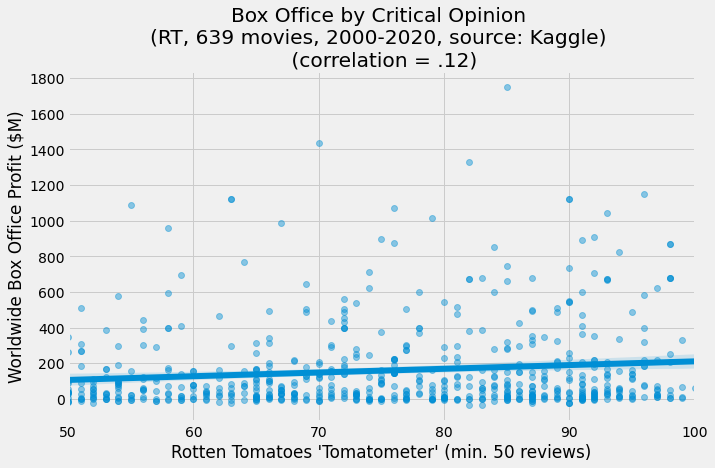

In [44]:
fig, ax = plt.subplots(figsize=(10,6))
x = merge_imdb_rt_kaggle.tomatometer_rating
y = merge_imdb_rt_kaggle['Worldwide Net Profit']
ax.scatter(x, y , alpha=.2)
sns.regplot(x=x,y=y,scatter_kws={'alpha':0.3})
ax.set_xlabel('Rotten Tomatoes \'Tomatometer\' (min. 50 reviews)')
ax.set_ylabel('Worldwide Box Office Profit ($M)')
ax.set_title('Box Office by Critical Opinion \n(RT, 639 movies, 2000-2020, source: Kaggle) \n (correlation = .12)')
ax.set_yticks(range(0,2000000000,200000000))
ax.set_yticklabels(range(0,2000,200));

Note:  The above plot confirms the there is little correaltion between critical consensus and box office profits.